## 1위 : XGBoost
- https://dacon.io/competitions/official/235736/codeshare/2877?page=1&dtype=recent

In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.10.8 (main, Nov 24 2022, 08:08:27) [Clang 14.0.6 ]
pandas version: 2.1.1
numpy version: 1.26.1
matplotlib version: 3.8.0
tqdm version: 4.66.1
sktime version: 0.24.0
xgboost version: 2.0.0
seaborn version: 0.13.0
scikit-learn version: 1.3.1
------------------------------------------------------------------------------


### 0. load libraries

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

### 1. preprocessing

- time series를 일반 regression 문제로 변환하기 위해 시간 관련 변수 추가(월 / 주 / 요일)
- 전력소비량의 건물별 요일별 시간대별 평균 / 건물별 시간대별 평균 / 건물별 시간대별 표준편차 변수 추가
- 건물별 요일별 시간대별 표준편차 / 건물별 평균 등 여러 통계량 생성 후 몇개 건물에 테스트, 최종적으로 성능 향상에 도움이 된 위 3개 변수만 추가
- 공휴일 변수 추가
- 시간(hour)는 cyclical encoding하여 변수 추가(sin time & cos time) 후 삭제
- CDH(Cooling Degree Hour) & THI(불쾌지수) 변수 추가
- 건물별 모델 생성 시 무의미한 태양광 발전 시설 / 냉방시설 변수 삭제

In [3]:
train=pd.read_csv('../data/elec/train.csv',encoding='cp949')
test=pd.read_csv('../data/elec/test.csv', encoding='cp949')
submission=pd.read_csv('../data/elec/sample_submission.csv')

In [4]:
## 변수들을 영문명으로 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind','hum' ,'prec', 'sun', 'non_elec', 'solar']
train.columns = cols

In [5]:
# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month

건물별, 요일별, 시간별 발전량 평균

In [6]:
power_hour_mean = pd.pivot_table(train, values='power', index = ['num', 'hour', 'day'],
                            aggfunc=np.mean
                            ).reset_index()
power_hour_mean.head(30)

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_11331/3313364531.py:1: FutureWarning: The provided callable <function mean at 0x10a26fb50> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  power_hour_mean = pd.pivot_table(train, values='power', index = ['num', 'hour', 'day'],


,num,hour,day,power
0,1,0,0,8528.627077
1,1,0,1,8505.972000
2,1,0,2,8518.392000
3,1,0,3,8548.686000
4,1,0,4,8560.674000
5,1,0,5,8567.802000
6,1,0,6,8553.438000
7,1,1,0,8513.723077
8,1,1,1,8442.414000
9,1,1,2,8503.380000


In [7]:
train['hour_mean'] = train.apply(lambda x : \
    power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,
                        'power'].values[0], axis = 1)

In [8]:
train.head()

,num,date_time,power,temp,wind,hum,prec,sun,non_elec,solar,hour,day,month,hour_mean
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,6,8528.627077
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,6,8513.723077
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,6,8496.625846
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,6,8480.076923
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,6,8472.051692


같은 방법으로 발전량 평균 넣어주기

In [9]:
power_hour_std = pd.pivot_table(train, values='power', index = ['num', 'hour'],
                            aggfunc=np.std
                            ).reset_index()

train['hour_std'] = train.apply(lambda x : \
    power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,
                        'power'].values[0], axis = 1)

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_11331/1478953459.py:1: FutureWarning: The provided callable <function std at 0x10a26fc70> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  power_hour_std = pd.pivot_table(train, values='power', index = ['num', 'hour'],


In [10]:
## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

In [11]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train.drop(['non_elec','solar','hour'], axis = 1, inplace = True)

In [12]:
train.head()

,num,date_time,power,temp,wind,hum,prec,sun,day,month,hour_mean,hour_std,sin_time,cos_time,THI,CDH
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0,6,8528.627077,118.793252,0.000000,1.000000,57.5376,-8.4
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0,6,8513.723077,137.989738,0.258819,0.965926,57.0389,-16.7
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0,6,8496.625846,122.381197,0.500000,0.866025,56.6789,-25.2
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0,6,8480.076923,122.054777,0.707107,0.707107,55.9589,-34.1
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0,6,8472.051692,124.472447,0.866025,0.500000,56.4576,-43.1


In [13]:
## 7번 건물의 발전량
y = train.loc[train.num == 7, 'power']
x = train.loc[train.num == 7, ].iloc[:, 3:]

In [14]:
# 마지막 일주일을 val set으로 설정
y_train, y_valid, X_train, X_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

In [15]:
print('train data shape\nx:{}, y:{}'.format(X_train.shape, y_train.shape))

train data shape
x:(1872, 13), y:(1872,)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='power'>)

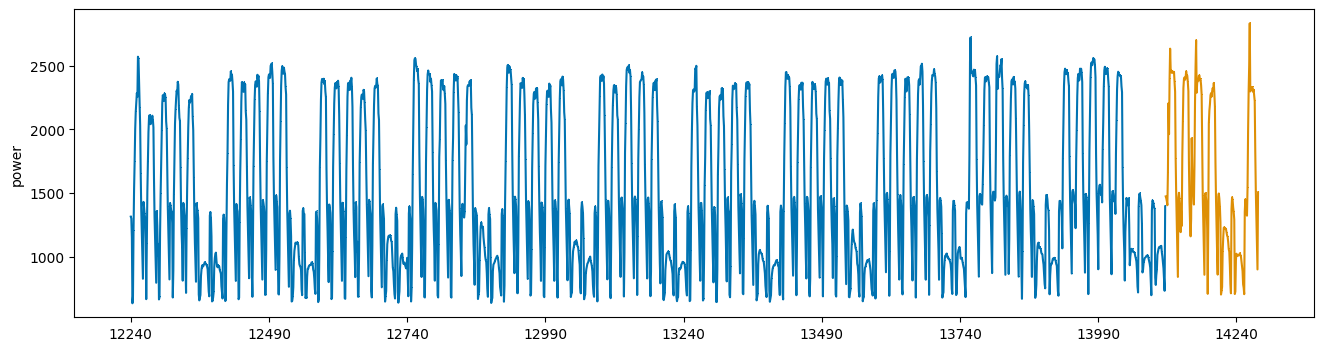

In [16]:
plot_series(y_train, y_valid, markers=[',', ','])

### 2. model: xgboost

In [17]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

- 평가 Metric인 SMAPE는 실제값보다 작게 추정할 때 더 좋지 않습니다.
- 이는 전력사용량을 높게 예측하는 것보다 작게 예측할 때 실제로 더 큰 문제가 될 수 있음을 반영한 것으로 보입니다.

In [18]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


- 그러나 일반 mse를 objective function으로 훈련할 때 과소추정하는 건물들이 있음을 확인했습니다.
- 이때문에 SMAPE 점수가 높아진다고 판단, 이를 해결하기 위해 아래와 같이 objective function을 새로 정의했습니다.
- 새 목적함수는 residual이 0보다 클 때, 즉 실제값보다 낮게 추정할 때 alpha만큼의 가중치를 곱해 반영합니다.
- XGBoost는 custom objective function으로 훈련하기 위해선 아래와 같이
- gradient(1차 미분함수) / hessian(2차 미분함수)를 정의해 두 값을 return해주어야 합니다.

In [19]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [20]:
xgb_reg = XGBRegressor(
    n_estimators = 10000,
    seed = 0
)

In [21]:
xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=300,
            verbose=False
            )

/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

best iterations: 6
SMAPE : 5.464590937813822


/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

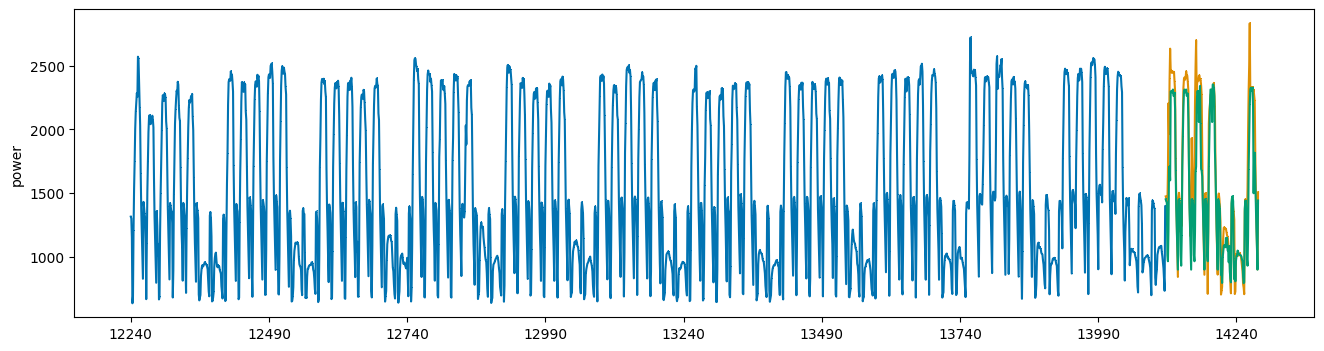

In [22]:
## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(X_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

In [23]:
xgb_reg = XGBRegressor(
    n_estimators = 10000,
    seed = 0
)

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=300,
            verbose=False
            )

/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None,
             objective=<function weighted_mse.<locals>.weighted_mse_fixed at 0x2926b28c0>, ...)

best iterations: 18
SMAPE : 4.461816893199162


/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/sguys99/opt/anaconda3/envs/tabular/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

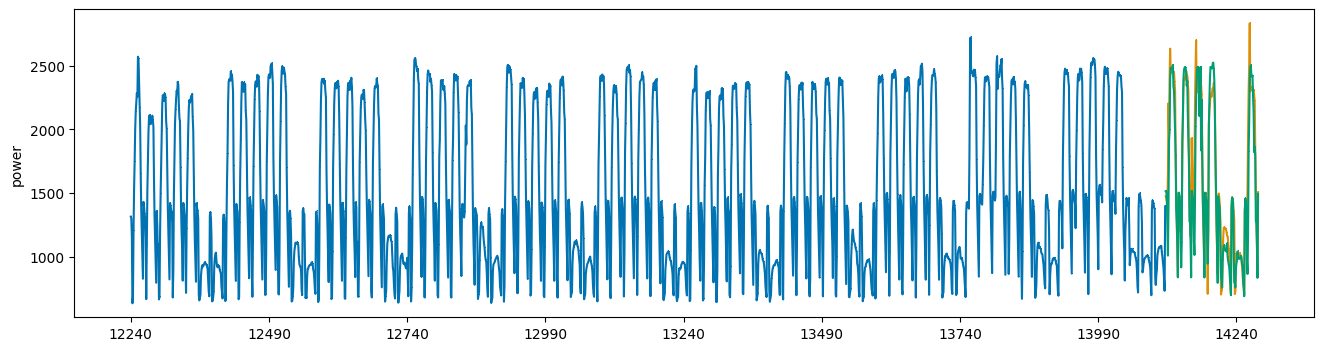

In [24]:
## SMAPE 값으로도, 그래프 상으로도 과소추정이 모델이 개선되었음을 확인
pred = xgb_reg.predict(X_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

### 3. 모델 튜닝: 생략

### 4. test inference